In [1]:
# @ Author: Wenbo Duan
# @ Email: bobbyduanwenbo@live.com
# @ Date: 23, Sep 2023
# @ Function: To evaluate the prediction quality of the GNN model


import torch
import torch.nn as nn
import torch_geometric
from torch_geometric.data import DataLoader
from customize_set import *
from model_zoo import *
import torch_geometric.transforms as T


device = 'cuda'


dataset = GC_30_aug('./data/GC_30_aug/')
data = DataLoader(dataset, batch_size = 1)

# essntial config files for the graph sets
edges_path = './data/GC_30_aug/original/edges.csv'
nodes_path = './data/GC_30_aug/original/nodes.csv'

model_path = 'NCC_30.pth'
baseline_model_path = 'NCC_20.pth'

/home/wd622/miniconda3/envs/GNN/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### starting from graph elimination

In [2]:
# generate nodel elimination results
import networkx as nx
import pandas as pd
from itertools import combinations
from collections import deque
import matplotlib.pyplot as plt
import os
from torch_geometric.utils.convert import from_networkx
import torch_geometric.transforms as T
from torch_geometric.utils import add_self_loops
import numpy as np
from customize_encoder import *


def load_backbone(checkpoint_path):
    print(f'loadining {checkpoint_path}')
    checkpoint = torch.load(checkpoint_path,map_location=torch.device(device))
    # model = NC_1(dataset.num_features, hidden=128).to(device)
    
    # model = GPSS(128, 8, 3).to(device) *_002.pth
    model = GPSS(128, 30, 3).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    last_loss = checkpoint['loss']
    print(f'last loss:{last_loss}\n')
    return model


def extract_graph(graph_id:int, edges_info:pd.DataFrame)->nx.Graph:
    # extract all pairwise nodes info from one graph
    egdes = edges_info[edges_info.graph_id == graph_id].iloc[:,1:].values.tolist()
    # adjust input format for networkx parsing
    egdes = [f'{i} {j}' for i,j in egdes]
    graph = nx.parse_adjlist(egdes)
    return graph

def extract_order(graph_id:int, nodes_info: pd.DataFrame) -> list:
    nodes = nodes_info[nodes_info.graph_id == graph_id].iloc[:,1:]
    nodes = nodes.sort_values(by=['node_label'])
    return nodes.node_id.values.tolist()


class EliminationEngine:
    def __init__(self, graph:nx.Graph, recordON=True) -> None:
        self.graph = graph
        self.graph_clone = graph.copy()
        self.fill_in_count = 0
        self.recordON = recordON
        # initalize all edge attribute as 1
        for edge in graph.edges:
            nx.set_edge_attributes(graph, {edge:{"edge_attr":1}})
        # initalize all node attribute as random
        for node in graph.nodes:
            nx.set_node_attributes(graph, {node:{"x":np.random.rand()}})

    def _add_fill_in(self, target_node):
        neighbors = self.graph.neighbors(target_node)
        potential_edges = combinations(neighbors,2)
        for edge in potential_edges:
            if edge not in self.graph.edges:
                self.graph.add_edge(edge[0], edge[1], edge_attr=1)
                if self.recordON:
                    # print(f'@Node {target_node}: Add fill-in between {edge[0]} and {edge[1]}')
                    self.fill_in_count += 1
                  
                              
    def eliminate(self, target_node):
        self._add_fill_in(target_node)
        self.graph.remove_node(target_node)
        return self.graph.copy()


class Eliminator(EliminationEngine):
    def __init__(self, graph: nx.Graph, recordON=True) -> None:
        super().__init__(graph, recordON)
        self.predict_order = []
        self.maps = []
    
    def reset_graph_label(self):
        mapping = {i:str(j) for j, i in enumerate(self.graph.nodes)}
        self.graph = nx.relabel_nodes(self.graph, mapping, copy=True)
        self.maps.append(mapping)
    

    def G2PG(self, graph):
        # convert networkx graph to PyG graph data
        x_dim = 3
        x = torch.rand(len(graph.nodes),x_dim,dtype=torch.float32)
        ed = [[int(e[0]), int(e[1])]  for e in list(graph.edges)]
        ed = torch.tensor(ed, dtype=torch.int64)
        edges = ed.t().contiguous()
        sample = Data(x, edges).to(device)
        return sample
    
    def embed(self, graph: nx.Graph):
        def add_self_loop(data):
            edge_index = add_self_loops(data.edge_index, data.edge_attr)
            data.edge_index = edge_index[0]
            data.edge_attr = edge_index[1]
            return data
        # convert the graph into the input for the model
        data = from_networkx(graph).to(device)

        transform_degree = AddDegree('degree')
        transform_localPE = AddLocalPE(walk_length=10, attr_name='pos_localPE')

        data = transform_degree(data)
        data = add_self_loop(data)
        data = transform_localPE(data)

        # add batch info
        data = DataLoader([data], batch_size=32)
        return list(data)[0]
    
    def step(self, predictor, random_level='l1',  mode = 'train'):
        while len(self.graph.nodes) > 1:
            if mode == 'eval':
                predictor.eval()
            else:
                predictor.train()
            # graph_tensor = self.G2PG(self.graph)
            graph_tensor = self.embed(self.graph)

            prediction_result = predictor(graph_tensor.degree, graph_tensor.pos_localPE, graph_tensor.edge_index, graph_tensor.batch, graph_tensor.edge_attr).argsort(0)
            if random_level == 'l1':
                target_node = prediction_result[-1].cpu().item()
            elif random_level == 'l2':
                target_node = random.choice(prediction_result[-2:]).cpu().item()
            else:
                target_node = random.choice(prediction_result[-3:]).cpu().item()
            self.eliminate(str(target_node))

            # recorver the node index to the begining graph
            for map in self.maps[::-1]:
                target_node = list(map.keys())[list(map.values()).index(str(target_node))]
            self.predict_order.append(target_node)
            self.reset_graph_label()
        
        # self.summary()

        # adding the last point
        target_node = '0'
        for map in self.maps[::-1]:
            target_node = list(map.keys())[list(map.values()).index(str(target_node))]
        
        self.predict_order.append(target_node)

        return self.predict_order, self.fill_in_count
      

    def auto_step(self,eliminate_seq:list):
        target_nodes = deque(eliminate_seq)
        while target_nodes:
            target_node = str(target_nodes.popleft())
            self.eliminate(target_node)
        if self.recordON:
            # self.summary()
            pass
        return self.fill_in_count
    

    def summary(self):
        print(f'Input Node Size: {len(self.graph_clone.nodes)}\nTotal fill-in: {self.fill_in_count}')



### Loading the Graph Data

In [3]:
# loading the graph and model
edges_info = pd.read_csv(edges_path)
nodes_info = pd.read_csv(nodes_path)
graph_ids = nodes_info.graph_id.unique()
print(f'{len(graph_ids)} graphs in total')

330 graphs in total


### Test on whole set

In [4]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore") 



def elimination_test(model, new_model, test_num):
    statistic = []
    result_set = []
    # for id in tqdm(graph_ids[:test_num]):
    for id in tqdm(graph_ids[:test_num]):
        graph = extract_graph(id, edges_info)
        truth_order = extract_order(id, nodes_info)
        eliminator = Eliminator(graph)
        fill_in_truth = eliminator.auto_step(truth_order)
        statistic.append({'id':id, "fill_in":fill_in_truth, "type":'Truth Order'})

        graph = extract_graph(id, edges_info)
        natrual_order = [i for i in range(len(graph.nodes))]
        eliminator = Eliminator(graph)
        fill_in_natrual = eliminator.auto_step(natrual_order)
        statistic.append({'id':id, "fill_in":fill_in_natrual, "type":'Random Order'})


        graph = extract_graph(id, edges_info)
        eliminator = Eliminator(graph)
        # model = load_backbone('backbone_0704.pth')
        predict_order, fill_in_predict = eliminator.step(model, random_level='l1')
        statistic.append({'id':id, "fill_in":fill_in_predict, "type":'Predict Order'})

        # refine model
        graph = extract_graph(id, edges_info)
        eliminator = Eliminator(graph)
        # model = load_backbone('backbone_0704.pth')
        predict_order, fill_in_predict = eliminator.step(new_model, random_level='l1')
        statistic.append({'id':id, "fill_in":fill_in_predict, "type":'Improved Model prediction'})

        # record the order info
        result_set.append({'graph_id':id, 'type': 'prediction', 'result':predict_order})
        result_set.append({'graph_id':id, 'type': 'ground truth', 'result':truth_order})

    sns.lineplot(data=pd.DataFrame(statistic),x='id', y='fill_in', hue='type')
    plt.figure()
    sns.displot(data=pd.DataFrame(statistic),x='fill_in',  hue='type',kind="kde")
    plt.xlabel('fill in count')
    return statistic, result_set


# model = load_backbone('backbone_002.pth')
# elimination_test(model, 100)

loadining NCC_30.pth
last loss:0.17648174124104635

loadining NCC_20.pth
last loss:0.20435338139533996



100%|██████████| 200/200 [01:25<00:00,  2.35it/s]


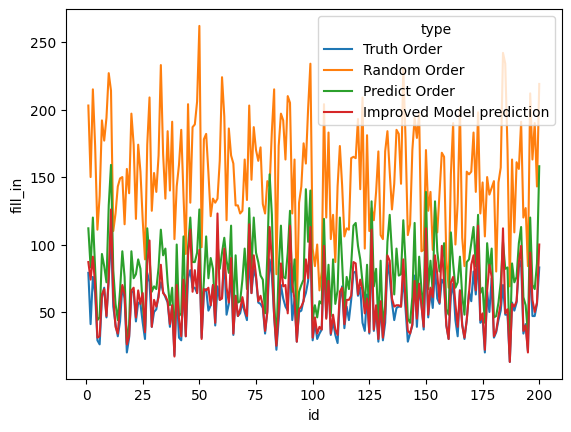

<Figure size 640x480 with 0 Axes>

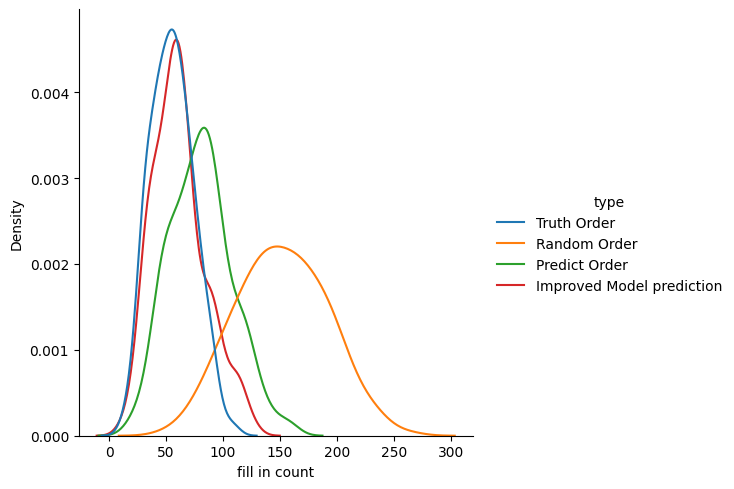

In [5]:
model = load_backbone(model_path)
new_model = load_backbone(baseline_model_path)
statistic, result_set = elimination_test(model, new_model, 200)
statistic_fill = pd.DataFrame(statistic)
statistic_order = pd.DataFrame(result_set)


### Quantitive Comparison

In [6]:
statistic_fill = pd.DataFrame(statistic)
statistic_order = pd.DataFrame(result_set)

In [7]:

## Ground Truth Statistic
# average fill in
statistic_gt = statistic_fill.loc[statistic_fill['type'] == 'Truth Order']
mean_fill_gt = statistic_gt['fill_in'].mean()
sigma_fill_gt = statistic_gt['fill_in'].var()

# Prediction Statistic
# average fill in
statistic_predict = statistic_fill.loc[statistic_fill['type'] == 'Predict Order']
mean_fill_predict = statistic_predict['fill_in'].mean()
sigma_fill_predict = statistic_predict['fill_in'].var()


# Random Statistic
# average fill in
statistic_random = statistic_fill.loc[statistic_fill['type'] == 'Random Order']
mean_fill_random = statistic_random['fill_in'].mean()
sigma_fill_random = statistic_random['fill_in'].var()

print(f'Mean - Fill in - Ground truth:{mean_fill_gt}')
print(f'Variance - Fill in - Ground truth:{sigma_fill_gt}')
print(f'Mean - Fill in - Prediction:{mean_fill_predict}')
print(f'Variance - Fill in - prediction:{sigma_fill_predict}')
print(f'Mean - Fill in - Random:{mean_fill_random}')
print(f'Variance - Fill in - Random:{sigma_fill_random}')

Mean - Fill in - Ground truth:55.245
Variance - Fill in - Ground truth:352.5376633165829
Mean - Fill in - Prediction:80.58
Variance - Fill in - prediction:742.8377889447238
Mean - Fill in - Random:151.71
Variance - Fill in - Random:1590.4782914572863


In [8]:
statistic_gt.reset_index(inplace=True, drop=True)
statistic_predict.reset_index(inplace=True, drop=True)

diff = pd.DataFrame(statistic_predict.fill_in - statistic_gt.fill_in)


graph_id = statistic_predict.id


diff = pd.concat([graph_id, diff], axis=1)

df = pd.DataFrame(statistic)

random_fill = df.loc[df.type=='Random Order'].fill_in
random_fill = random_fill.reset_index().fill_in
random_fill.name = 'random_fill'
random_fill = pd.DataFrame(random_fill)


gt_fill = df.loc[df.type=='Truth Order'].fill_in
gt_fill = gt_fill.reset_index().fill_in
gt_fill.name = 'gt_fill'
gt_fill = pd.DataFrame(gt_fill)




diff = pd.concat([diff, random_fill], axis=1)

diff = pd.concat([diff, gt_fill], axis=1)

diff['10p'] = diff['gt_fill']*0.1
diff['10pp'] = diff['fill_in'] - diff['10p']
diff['20p'] = diff['gt_fill']*0.2
diff['20pp'] = diff['fill_in'] - diff['20p']
diff['randomp'] = diff['fill_in'] - diff['random_fill']





In [9]:


s1 = diff.loc[diff.fill_in < 0].shape[0]
s2 = diff.loc[diff.fill_in == 0].shape[0]

s3 = diff.loc[(diff.fill_in > 0) & (diff['10pp'] < 0)].shape[0]
s4 = diff.loc[(diff['10pp'] >= 0) & (diff['20pp']< 0)].shape[0]
s6 = diff.loc[(diff.fill_in > 0) & (diff['20pp']>= 0)].shape[0]

s5 = diff.loc[(diff.fill_in > 0) & (diff.randomp < 0 )].shape[0]


print(f'< 0: {s1}\n=0 :{s2}\n 10p: {s3}\n20p: {s4}\n better than random: {s5}\n20p+: {s6}')

< 0: 0
=0 :0
 10p: 0
20p: 9
 better than random: 200
20p+: 191


In [10]:
import torch
import numpy as np
import pandas as pd

df = pd.DataFrame(statistic)
prediction = df.loc[df.type=='Predict Order'].fill_in.to_list()
ground_truth = df.loc[df.type=='Truth Order'].fill_in.to_list()


unique_value_pred = np.unique(prediction).tolist()
unique_value_ground = np.unique(ground_truth).tolist()
unique_value = list(set(unique_value_pred+unique_value_ground))

dist_pred = []
dist_ground = []

for fill_in_num in unique_value:
    dist_pred.append(prediction.count(fill_in_num))
    dist_ground.append(ground_truth.count(fill_in_num))

dist_pred = [i/sum(dist_pred) for i in dist_pred]
dist_ground = [i/sum(dist_ground) for i in dist_ground]

p = torch.tensor(dist_ground)
q = torch.tensor(dist_pred)

log_q = torch.log_softmax(q, dim=0)  # Convert q to log space
p = torch.softmax(p, dim=0)          # Convert p to probability space

KL_div = torch.nn.functional.kl_div(log_q, p, reduction='sum')

print(f'KL divergence between GT and predict: {np.log(KL_div.item())}')


df = pd.DataFrame(statistic)
prediction = df.loc[df.type=='Predict Order'].fill_in.to_list()
ground_truth = df.loc[df.type=='Random Order'].fill_in.to_list()


unique_value_pred = np.unique(prediction).tolist()
unique_value_ground = np.unique(ground_truth).tolist()
unique_value = list(set(unique_value_pred+unique_value_ground))

dist_pred = []
dist_ground = []

for fill_in_num in unique_value:
    dist_pred.append(prediction.count(fill_in_num))
    dist_ground.append(ground_truth.count(fill_in_num))

dist_pred = [i/sum(dist_pred) for i in dist_pred]
dist_ground = [i/sum(dist_ground) for i in dist_ground]

p = torch.tensor(dist_ground)
q = torch.tensor(dist_pred)

log_q = torch.log_softmax(q, dim=0)  # Convert q to log space
p = torch.softmax(p, dim=0)          # Convert p to probability space

KL_div = torch.nn.functional.kl_div(log_q, p, reduction='sum')

print(f'KL divergence between GT and random: {np.log(KL_div.item())}')

KL divergence between GT and predict: -9.5205596536926
KL divergence between GT and random: -9.590436519584635
